In [201]:
#Required Libraries
#Tidyverse for general data analysis
suppressMessages(library(tidyverse))
#glmnet for lasso
suppressMessages(library(glmnet))
#caret for confusion matrix
suppressMessages(library(caret))

## The Data:  
Data obtained from: https://archive.ics.uci.edu/dataset/2/adult , Adult income dataset.  
There are 32561 observations with 15 variables (14 explanatory, 1 response). The response variable used will be income, a binary variable with two values (income > 50k, income <= 50k, USD per year).   
The explanatory variables are as follows:  
$\textbf{age (integer)}$: ranges from 17-90, with mean 38.58 and median 37.00. Does not have any missing values (N/As). Likely to be a useful predictor (statistically significant effect on model estimation). Will be used in estimating initial model.    
$\textbf{workclass (categorical)}$: levels include: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. Encodes the area of work each observation falls within, May have some possible effect on model estimation, as some levels are obvious (without-pay, never-worked, etc), whereas the we cannot tell for the others before performing EDA. Will be used in estimating initial model.    
$\textbf{fnlwgt (integer)}$: Represents the number of entries this entry represents, not useful for prediction, will be dropped.  
$\textbf{education (categorical)}$: levels include: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. Encodes level of education of each observation. Possible positive relationship between level of education and income, cannot be sure of effect on model estimation until more data analysis is performed. Will be used in estimating initial model.  
$\textbf{education\_num (integer)}$ Equivalent to previous variable, except encodes education level as integers from 1-16. Will not be used (prefer categorical as numeric may interact unpredictably with parameter estimation). Will be dropped.  
$\textbf{marital-status (categorical)}$: Renamed to "marital" when imported above for easy of use. Levels include: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. Unknown effect on model estimation, will be used to estimate initial model.  
$\textbf{occupation (categorical)}$ Levels include: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. Variable likely to be unbalanced, not enough levels for all professions. Seems like many have been grouped together which may result in unbalanced group numbers. Can not know for sure until EDA performed, will keep in intial model estimation.  
$\textbf{relationship (categorical)}$ Levels include: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. Highly likely to be collinear with $\textbf{marital-status}$ above. Will be dropped in favour of said variable in intial model estimation.  
$\textbf{race (categorical)}$ Levels include: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. Effects unknown until more data analysis is performed, may also have unbalanced levels. Will keep in inital model estimation.  
$\textbf{sex (categorical)}$ Levels include: Female, Male. Likely to be some effect, will keep in initial model estimation.  
$\textbf{capital gain (integer)}$ ranges from 0-99999, with mean 1078, median 0. Likely to have direct effect on income, will be in initial model estimation.  
$\textbf{capital loss (integer)}$ ranges from 0-4356, with mean 87.3, median 0. Likely to have direct effect on income, will be in initial model estimation.  
$\textbf{hours-per-week (integer)}$ ranges from 1 to 99, with mean 40.44, median 40. Likely to have direct effect on income, will be in initial model estimation.  
$\textbf{native-country (categorical)}$ levels include: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. Likely some effect due to differences in minimum wage\cost of living\tax amount, however none of these factors are included in the actual dataset, and thus this factor is likely correlated with many hidden factors; also only around 10% of the data is from outside of the United States, thus this variable will be dropped.  

We will use most explanatory variables in the initial model estimation, and compare test scores on validation sets against models selected with different criteria (forward/backward/all subset regression, ridge/lasso, etc.). Also, as the response is binary, we will be utilizing a logistic regression model.  

To Clarify, predictors we will use for model estimation: age, education, marital-status,race,sex,capital gain, capital loss, hours per week.  

## Research Question:  
We propose the following predictive question on the estimation of underlying statistical model to the dataset of: "Which of the following factors of age, education level, occupation, working class, marital status, race, sex, capital gain and loss per year, and hours per week are included in a model with the best predictive ability on unseen adult income data?"

## Exploratory Data Analysis

In [187]:
#Tidy data; although UCI database already contains data in a somewhat tidy format:
#We directly import the dataset from the online UCI dataset archive, and rename variables for readability:
adult_tidy = read.table("http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        sep=",",header=F,col.names=c("age", "workclass", "fnlwgt", "education", 
                "education_num","marital", "occupation", "relationship", "race","sex",
                "capital_gain", "capital_loss", "hr_per_week","country", "income"),
        fill=FALSE,strip.white=T)
#deal with N/A values, drop non useful factors:
adult_tidy = na.omit(adult_tidy) |> select(-relationship, -education_num, -fnlwgt,-country)
head(adult_tidy)

,age,workclass,education,marital,occupation,race,sex,capital_gain,capital_loss,hr_per_week,income
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
1,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,2174,0,40,<=50K
2,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,0,0,13,<=50K
3,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,0,0,40,<=50K
4,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,0,0,40,<=50K
5,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,0,0,40,<=50K
6,37,Private,Masters,Married-civ-spouse,Exec-managerial,White,Female,0,0,40,<=50K


## Visualization  
$\textbf{We start with barcharts to investiate the relationships between categorial predictors with the response:}$

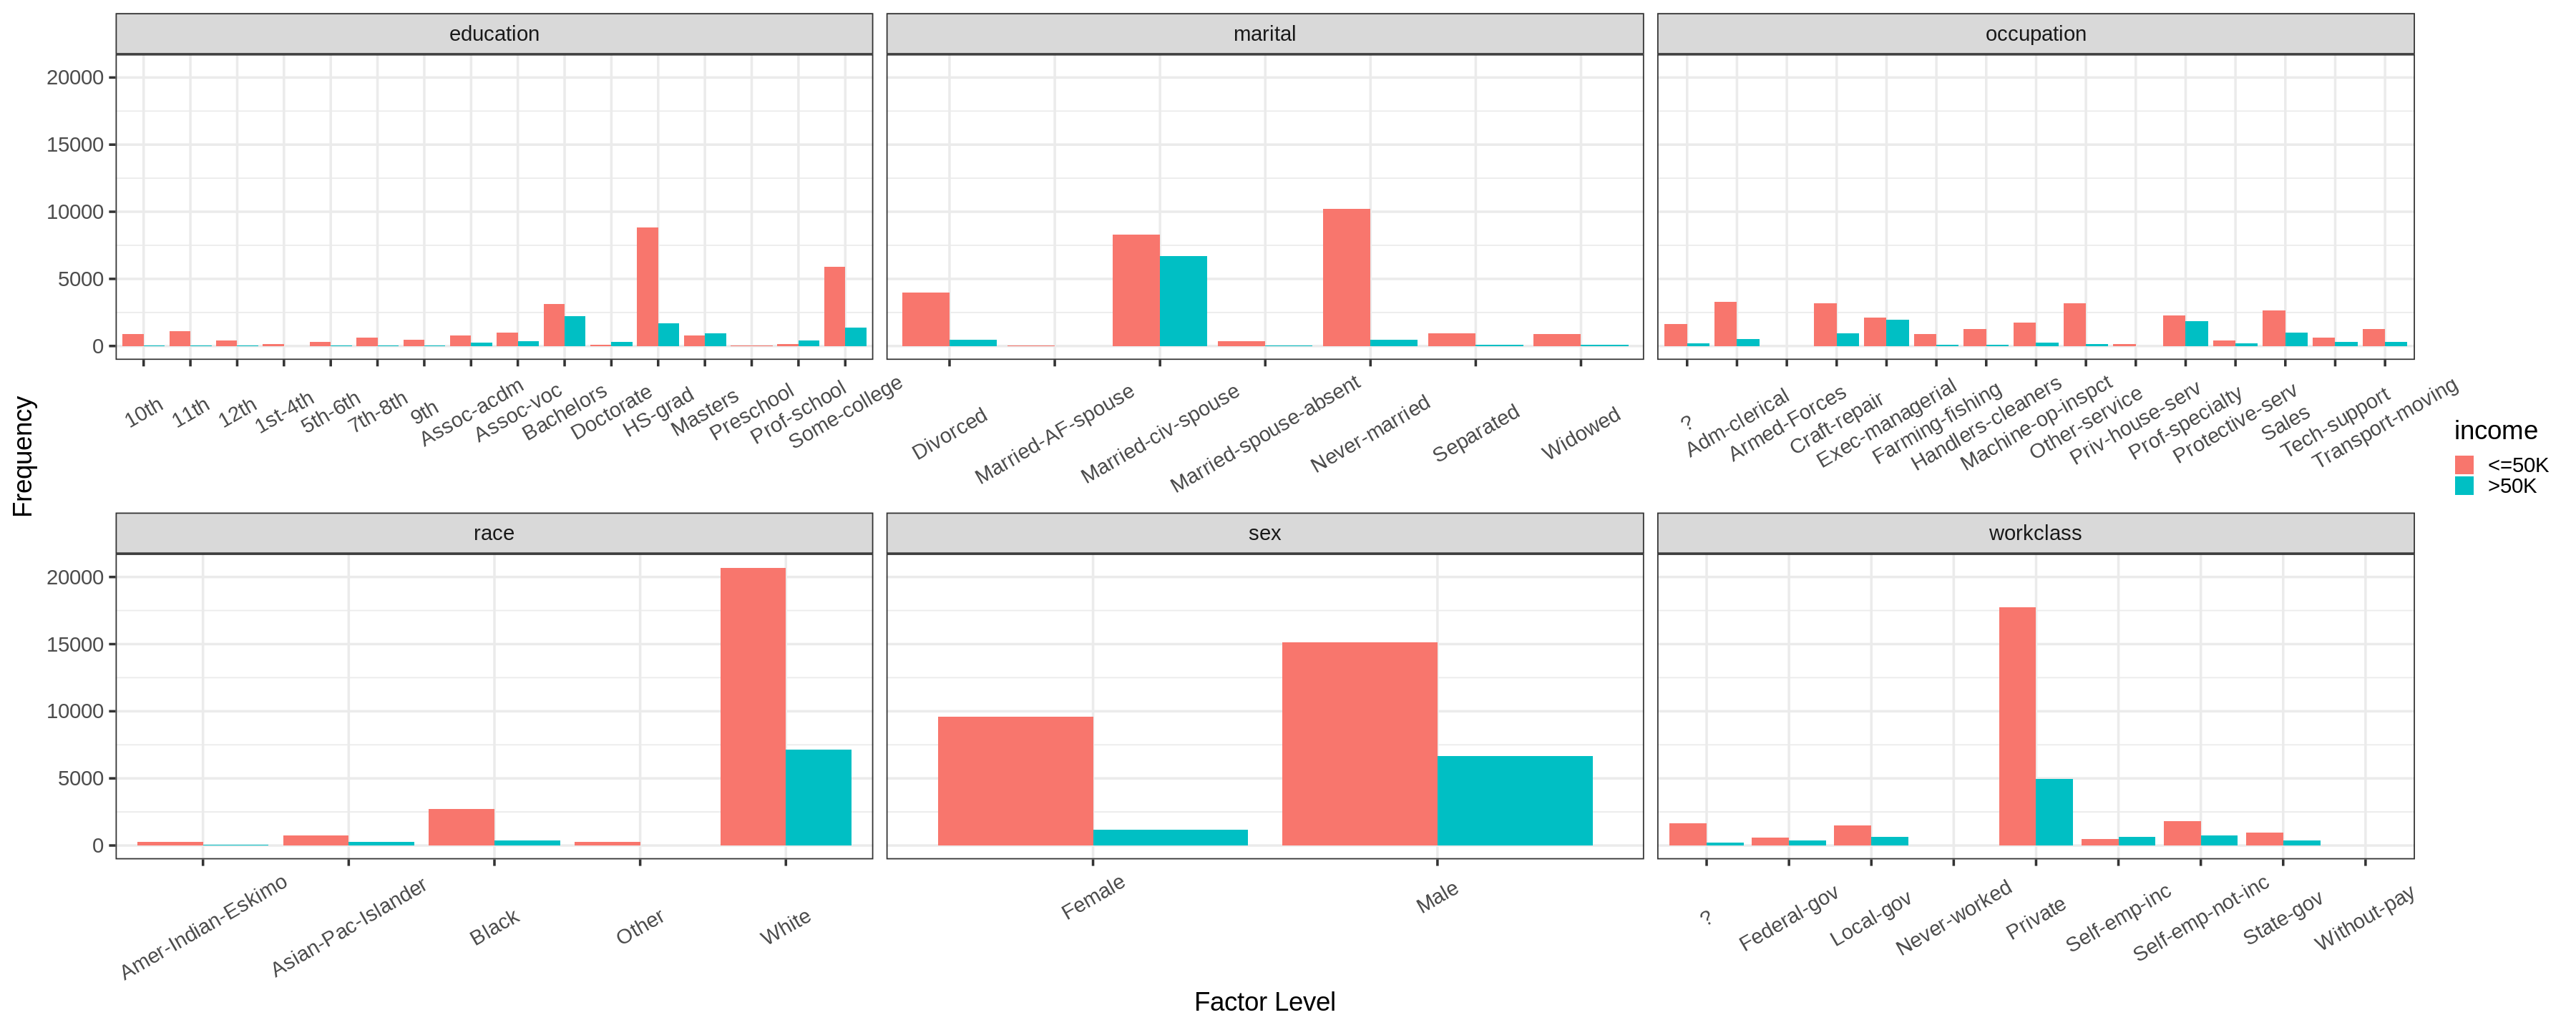

In [188]:
#Resize plots to be more readable
options(repr.plot.width=30, repr.plot.height=12)
#Select needed variables
adult_cat = as.data.frame(unclass(adult_tidy |> select(-age,-capital_gain,-capital_loss,-hr_per_week)),stringsAsFactors=TRUE)
#turn data into long format, easier for ggplot to work with.
adult_cat_long = suppressWarnings(gather(adult_cat, key = "variable", value = "value", education, marital, race, sex,workclass,occupation))

#Create faceted bar charts:
adult_barcharts = ggplot(adult_cat_long, aes(x = value, fill = income)) +
  geom_bar(position="dodge",stat = "count") +
  facet_wrap(~ variable, scales = "free_x") +
  theme_bw(base_size = 22) +
  labs(x = "Factor Level", y = "Frequency") +
  theme(axis.text.x = element_text(angle = 30,vjust = 0.5))
suppressWarnings(print(adult_barcharts))


In the above plots, we see overall there is a discrepancy in number of observations with income <= 50k, and income >50k, with overall less observations including an income over 50k. Also, there is quite a large imbalance in number of observations within factor levels, which can be seen most obviously from the race, education and workclass factors, with the majority of observations being white, the majority of observations with education level as Highschool graduates or with some level of college education, and the majority of observations working in the private sector. These unbalanced factors may affect the intercept of the estimated logistic model, which will affect the accuracy of the predictive ability of the model. We may be able to correct for this using ROC curves to adjust the prediction threshold, or correct for rare events by resampling a balanced sample from our current data. However, there does seem to be clear patterns within each factor of some relationship between these factors and our response, income, on a relative basis. For example, in the marital factor chart we can obviously see an almost equal balance between income levels for observations that are married with a civilian spouse, despite on average there being less observations with a income >50k. This can also be seen in the education chart with a somewhat-even balance in income levels for observations with a bachelors degree, and even a greater amount of observations with income >50k for observations with a professional school or graduate school level education (despite their low overall observation counts). These suggest that these factors would likely have some effect on our estimated model.

$\textbf{We now use side-by-side boxplots to visualize the relationship between quantitative predictors and Income:}$

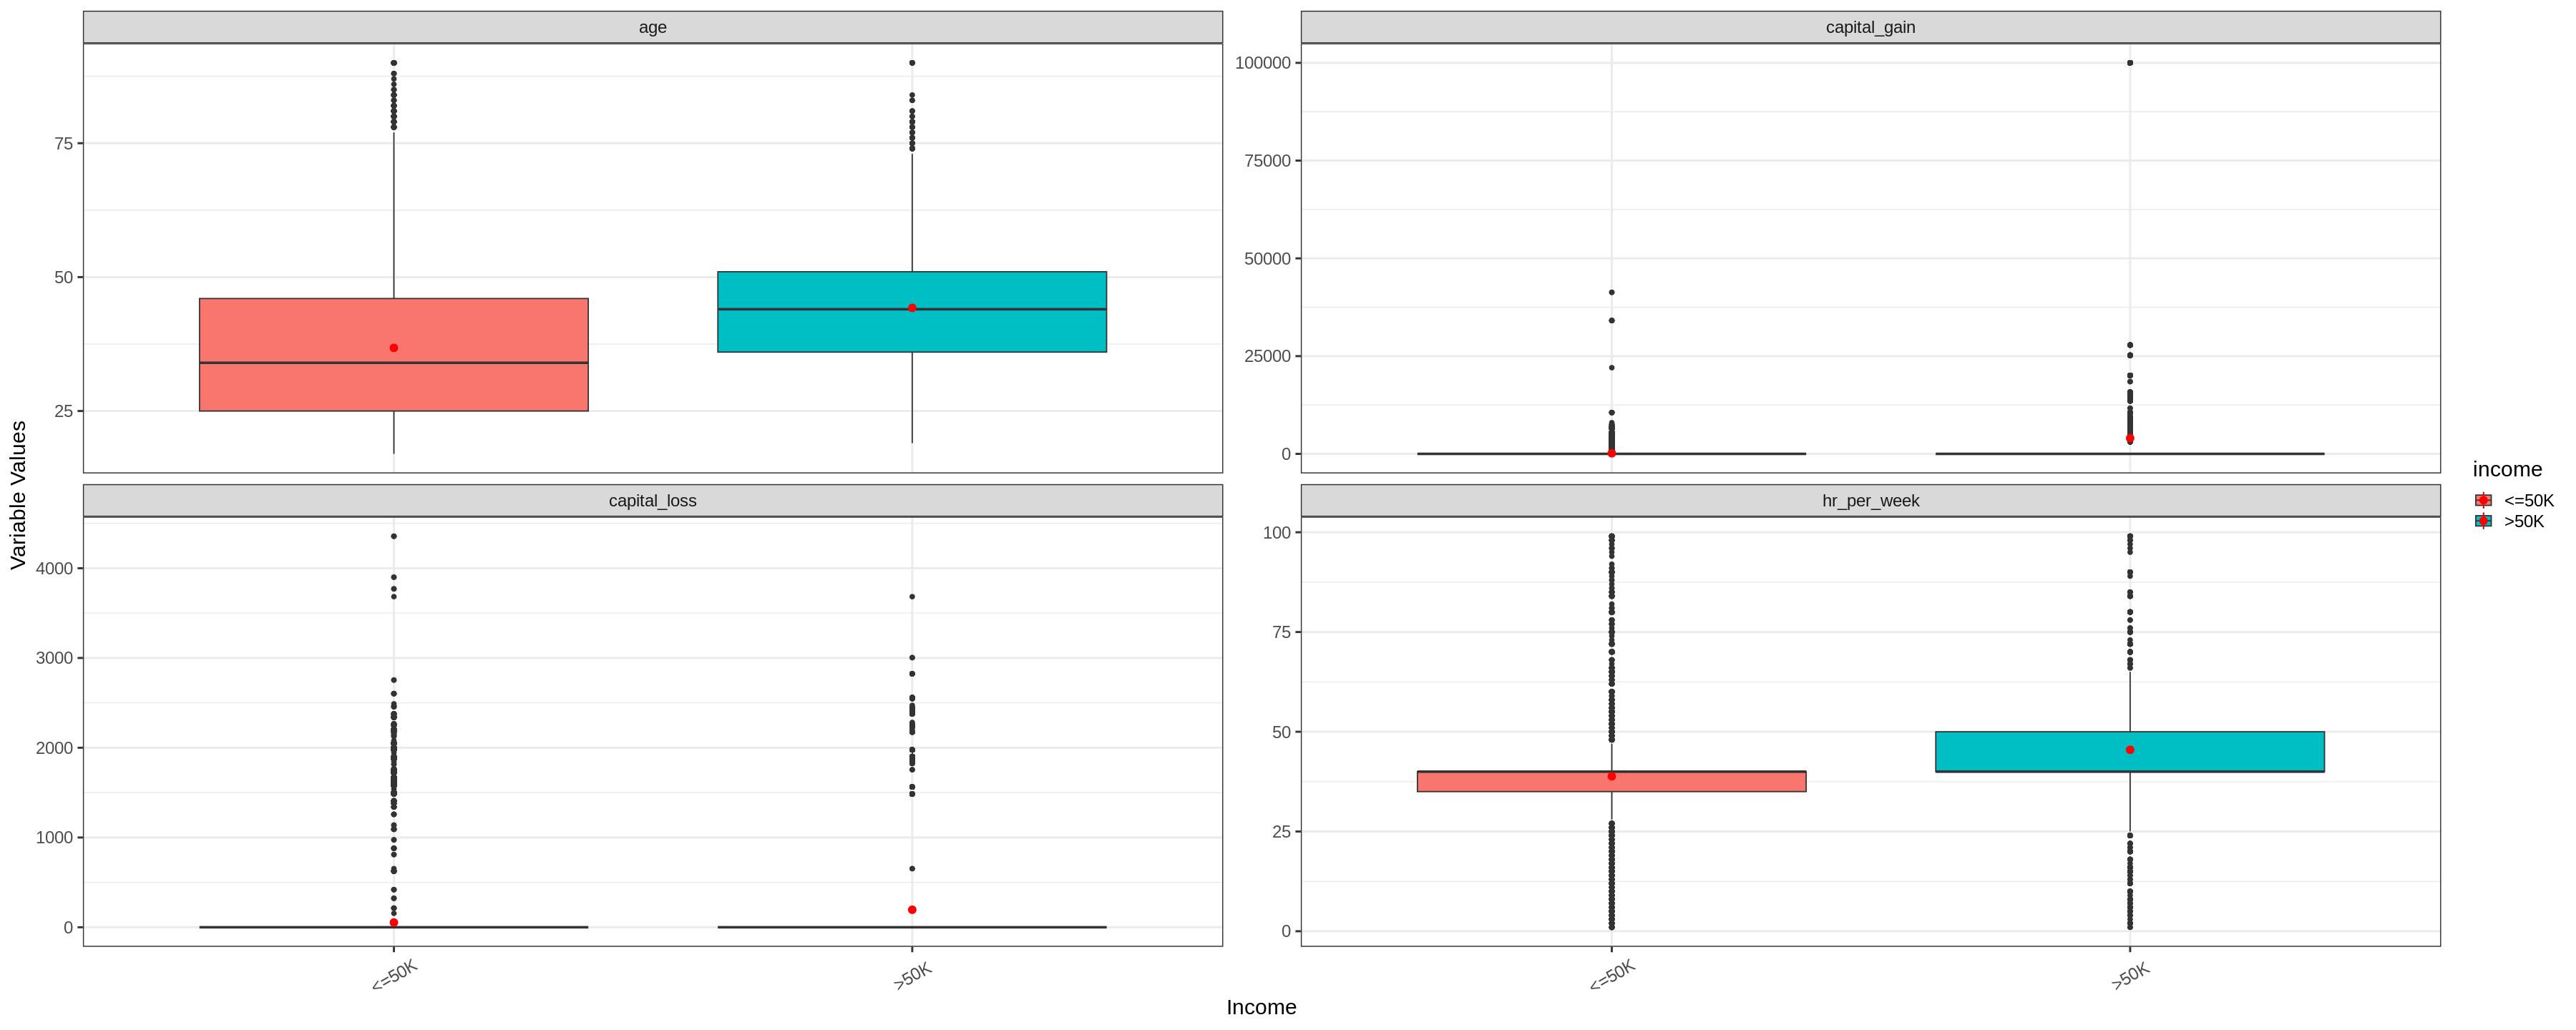

In [189]:
#similar steps to categorical data
adult_quant = adult_tidy |> select(age,capital_gain,capital_loss,hr_per_week,income)
adult_quant_long = gather(adult_quant, key = "variable", value = "value", age, capital_gain, capital_loss, hr_per_week)
adult_boxplots = ggplot(adult_quant_long, aes(y = value, x = income, fill = income)) +
  geom_boxplot() + stat_summary(fun="mean", colour = "red") +
  facet_wrap(~ variable, scales = "free_y") +
  theme_bw(base_size = 18) +
  labs(x = "Income", y = "Variable Values") +
  theme(axis.text.x = element_text(angle = 30,vjust = 0.5))
suppressWarnings(print(adult_boxplots))

from the plots above, it appears that regardless of income level, the data generally spans the same ranges. However, the quantiles and mean (the red dot) of each variable is higher for income >50k. The distributions of hours per week worked appears the most similar, with the same median. However, the income >50k boxplot has a higher 75% quantile, whereas the income <=50k has a 75% quantile approximately equal to its median. The boxplots of capital loss and capital gain give rise to some possible issues. The boxplots indicate that there are many 0's within the data, which may lead to the patterns appearing being due to sampling variation or outliers, as the actual non-zero sample size is very small. This may result in logistic regression curves having lower performance despite being robust towards outliers. These issues may be addressed via model selection procedures such as k-fold CV.

## Methods and Plan:  
We decide to use 2 methods for model selection: forward stepwise selection and logistic LASSO:  
  
First, we will create a 75/25 train-test split on the data in order to choose between the two model selection methods at the end.  
$\textbf{Forward stepwise selection:}$
We will use a forward stepwise selection algorithm on the training set with the regsubsets function from the leaps package, with no variables forced in or out. We will then calculate AIC, BIC and Cp values for each model to select the best subset (in the case where these values do not agree, we will prefer the model selected by BIC, as this penalizes larger models more harshly compared to AIC and Cp, preferring smaller models (thus higher bias, lower variance and lower overfitting). This is due to the fact that we will also be performing logistic lasso to compare, a selection method which also prefers smaller models with fewer predictors.   

Limitations of Forward Stepwise Selection:  
Since forward stepwise selection is a greedy algorithm (in that it will never remove a predictor that has already been added to the model in a previous step) this may lead to the algorithm only selection one of several collinear predictors, which may not be the most representative predictor within the dataset. Also, this algorithm does not take interactions into account. This algorithm may also miss important predictors who's effects are only effective if another (weaker) predictor is included in the model as well. As the significance of predictors relies on their p-value, this may cause issues as more predictors are added due to the multiple comparison problem. Finally, this algorithm is also prone to overfitting on the data, as it calculates the goodness of fit statistics on the training data. 

$\textbf{Logistic LASSO:}$
For logistic LASSO, we will use the cv.glmnet function from the glmnet package, with alpha = 1 to specify lasso and family = "binomial" to specify logistic regression. This will perform k-fold cross validation to find the optimal lambda value associated with the best performing model (using log-loss). We will instead choose to use the 1-standard error lambda value (the smallest model with lambda within 1 standard deviation of the best performing lambda value), as this errs on the side of underfitting instead of overfitting the data, accounting for errors in estimating the parameters of the model.  

Limitations of Lasso:  
LASSO may underestimate the complexity of the underlying model, as it prefers smaller models due to the regularization. It also suffers from the same issue as best subset for collinear predictors, where it may not choose the best performing one. Also, LASSO does result in higher bias models, due to the shrinkage from regularization. 

Finally, we will compare the two best models chosen between Logistic LASSO and forward stepwise selection using the testing set, comparing their log-loss performance on this set, and should the two models not agree, choose the model with the best performance. Otherwise, report the models performance on the testing set.

## Implementation of a Proposed Model

In [190]:
#set seed for reproducibility
set.seed(2023)
#split data:
#first convert adult tidy to 0/1 response variable:
adult_binary <- adult_tidy |> mutate(income = ifelse(income == ">50K",1,0))
to_split <-  adult_binary %>% mutate(id=row_number())
train_data <- slice_sample(to_split, prop=0.75) 
test_data <- anti_join(to_split,train_data,by="id") |> select(-id)
train_data <- train_data |> select(-id)

In [191]:
#lasso cv on train data:
#encode dummy variables for categorical predictors and generate design matrix:
X <- model.matrix(~., data = train_data |> select(-income)) 
y <- train_data$income
lasso_cv <- cv.glmnet(x=X,y=y, alpha=1, family="binomial",nfolds=10)

In [1]:
#display cv plot for different lambdas:
#commented out for 1 table/figure limit, going to use confusion matrix
#plot(lasso_cv)
lasso_cv$lambda.1se

ERROR: Error in eval(expr, envir, enclos): object 'lasso_cv' not found


In [202]:
#make predictions using lasso_cv object with the 1se lambda
pred <- predict(lasso_cv,newx=model.matrix(~., data = test_data |> select(-income)),s="lambda.1se")
probs <- exp(pred)/(1+exp(pred))
class_pred <- ifelse(probs <= 0.5,0,1)
confusionMatrix(
    data = as.factor(class_pred),
     reference = as.factor(test_data$income),
     positive = "1"
    )

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5756  850
         1  396 1139
                                          
               Accuracy : 0.8469          
                 95% CI : (0.8389, 0.8547)
    No Information Rate : 0.7557          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5508          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5726          
            Specificity : 0.9356          
         Pos Pred Value : 0.7420          
         Neg Pred Value : 0.8713          
             Prevalence : 0.2443          
         Detection Rate : 0.1399          
   Detection Prevalence : 0.1886          
      Balanced Accuracy : 0.7541          
                                          
       'Positive' Class : 1               
                        

We had to change the response variable to numeric boolean 0/1, as this is required for logistic regression with glmnet. We had to manually create dummy variables for all the factor levels and change them to 0/1 values as well, as glmnet does not have this functionality built in, which resulted in a total of 53 predictors. This may mean that more (if not all) of these categorical variables should be excluded or grouped lasso should be done instead (where whole categories are dropped instead of dummy variables), in further analysis. Despite this, our final model had a 1se lambda value of 0.00283771197329677, who's fitted model achieved an accuracy of $84.69\% \approx 85\%$ on the validation set, which is quite good, however it has low sensitivity which means it is failing to classify positive cases accurately, which may be due to the overabundance of negative cases.